# Parzen-Window Classification of Geometric Shapes

In [84]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KernelDensity
from sklearn.metrics import accuracy_score, classification_report

In [86]:
# Function to generate synthetic shape images
def generate_shape(shape, size=64):
    img = np.zeros((size, size), dtype=np.uint8)
    center = (size // 2, size // 2)
    if shape == "circle":
        cv2.circle(img, center, size // 3, 255, -1)
    elif shape == "square":
        cv2.rectangle(img, (size//4, size//4), (3*size//4, 3*size//4), 255, -1)
    elif shape == "triangle":
        pts = np.array([[size//2, size//5], [size//5, 4*size//5], [4*size//5, 4*size//5]], np.int32)
        cv2.fillPoly(img, [pts], 255)
    return img

In [88]:
# Extract Hu Moments from image
def extract_hu_moments (image):
    moments = cv2.moments(image)
    hu = cv2.HuMoments (moments).flatten()
    return -np.sign(hu) * np.log10(np.abs(hu) + 1e-10) # Log transform for stability

In [90]:
shapes = ["circle", "square", "triangle"]
# Generate dataset
def create_dataset(num_samples=100):
    X, y = [], []
    for i, shape in enumerate (shapes):
        for _ in range(num_samples):
            img = generate_shape(shape)
            X.append(img.flatten())
            y.append(i)
    return np.array (X), np.array(y)

X, y = create_dataset(300)

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [94]:
# Parzen Window (KDE) Classifier
kde_models = []
for label in np.unique(y_train):
    kde = KernelDensity (kernel='gaussian', bandwidth=8.5)
    kde.fit(X_train[y_train == label])
    kde_models.append(kde)

In [96]:
# Predict using Parzen KDE
log_probs = np.array([kde.score_samples (X_test) for kde in kde_models]).T
y_pred_parzen = np.argmax(log_probs, axis=1)

In [98]:
#k-NN Classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

In [100]:
# Evaluation

print("=== Parzen-Window Classifier ===")
print("Accuracy:", accuracy_score(y_test, y_pred_parzen))
print(classification_report(y_test, y_pred_parzen, target_names=shapes))

=== Parzen-Window Classifier ===
Accuracy: 1.0
              precision    recall  f1-score   support

      circle       1.00      1.00      1.00        60
      square       1.00      1.00      1.00        67
    triangle       1.00      1.00      1.00        53

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180



In [102]:
print("\n=== k-NN Classifier ===")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn, target_names=shapes))


=== k-NN Classifier ===
Accuracy: 1.0
              precision    recall  f1-score   support

      circle       1.00      1.00      1.00        60
      square       1.00      1.00      1.00        67
    triangle       1.00      1.00      1.00        53

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180



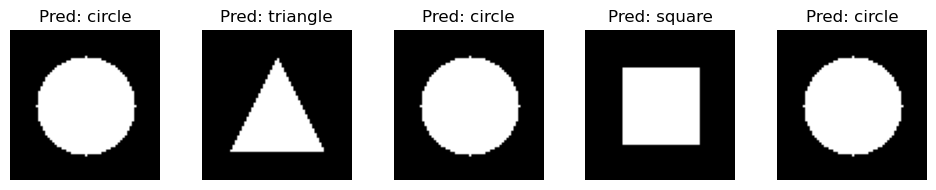

In [106]:
fig, axes = plt.subplots (1, 5, figsize=(10, 2))
for i in range(5):
    true_label = y_test[i]
    pred_label = y_pred_parzen[i]
    # Regenerate image from shape Label
    shape_name = shapes[true_label]
    img = generate_shape(shape_name)

    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(f"Pred: {shapes[pred_label]}")
    axes[i].axis("off")
    plt.tight_layout()
plt.show()